In [334]:
# read tiff file (video)
# divide video into pictures by 1 second
# for each picture:
# divide it into 3 channels

# channel 0 - red (nucleus sizes, number of viable cells)
# channel 1 - green (protein expression, cell size, mask for mRNA calculation)
# channel 2 - blue (mRNA nucleus, mRNA cytoplasm, transcripton sites number and intensity)

# segmentation and binarization (counting 0 pixels for size, founding shapes and counting middle points (localization) as number of cells or transcription sizes)
# segmented nucleus as mask to divide mRNAs into nucleus / cytoplasm, and then we can count points and intewnsity


In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations

from skimage import io, measure               # Module from skimage
from skimage.filters import gaussian # Module working with a gaussian filter                           # Library to work with file paths
import os
%matplotlib inline

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io, color as ski_color, filters as ski_filters
from PIL import Image
import cellpose


In [336]:
os.listdir()

['.DS_Store',
 '.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 'Drug10_1000nM',
 'Drug1_1000nM',
 'Drug4_1000nM',
 'Final_project.ipynb',
 'first_steps_Wiktoria2.ipynb',
 'imageProcessorTest.ipynb',
 'image_cell.tif',
 'NoDrug',
 'Project_Jakini.ipynb',
 'Project_Pilar.ipynb']

In [2]:
image_path = str("Drug1_1000nM/rep1_FOV1.tif")
images = imread(image_path)

In [3]:
# Printing the shape of the image
print('Original image shape: ' , images.shape)  # [T,Y,X,C]

# Selecting a frame and a color channel
img = images[0,:,:,0]
print('Single image shape: ' , img.shape)  # [Y,X]


Original image shape:  (21, 650, 650, 3)
Single image shape:  (650, 650)


[Text(0.5, 1.0, 'B')]

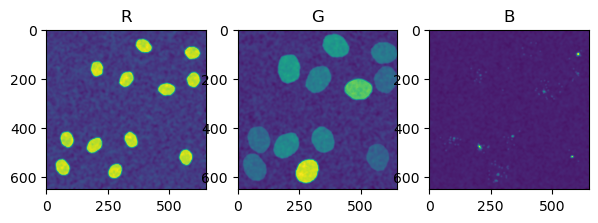

In [4]:
# channel 0 - red (nucleus sizes, number of viable cells)

[T,Y,X,C] = images.shape
test_image = images.copy()
threshold = 130

img_R = test_image[1,:,:,0]
img_G = test_image[1,:,:,1]
img_B = test_image[1,:,:,2]

fig, ax = plt.subplots(1,3, figsize=(7, 7))

ax[0].imshow(img_R)
ax[0].set(title='R')

ax[1].imshow(img_G)
ax[1].set(title='G')

ax[2].imshow(img_B)
ax[2].set(title='B')
    

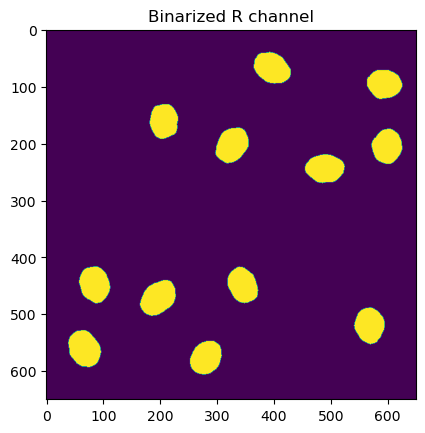

In [5]:
#take R channel and binarize it
threshold = 130
img_R_bin = img_R > threshold
img_R_bin = img_R_bin.astype(int)
#plot binarized image
plt.imshow(img_R_bin)
plt.title('Binarized R channel')
plt.show()

Number of cells:  12


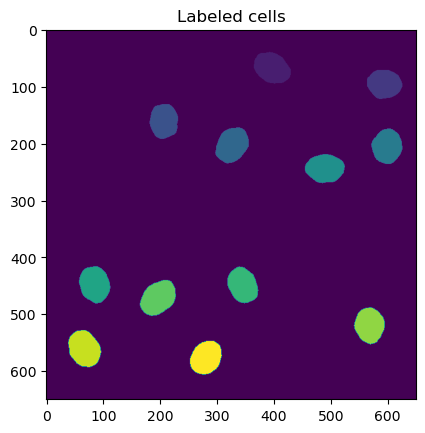

Obszary komórek: [2711.0, 2459.0, 2427.0, 2735.0, 2525.0, 2680.0, 2676.0, 2556.0, 2873.0, 2567.0, 2828.0, 2555.0]


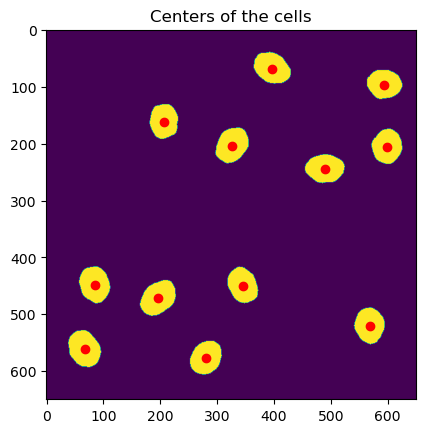

In [6]:
#using binarized image give me the number of cells and their middle points
#labeling the cells
img_R_label = measure.label(img_R_bin)
#counting the number of cells
num_cells = img_R_label.max()
print('Number of cells: ', num_cells)

#plotting the labeled cells
plt.imshow(img_R_label)
plt.title('Labeled cells')
plt.show()

#print location of the cells
#finding the center of the cells
props = measure.regionprops(img_R_label)

# Zbieranie obszarów komórek
cell_areas = [region.area for region in props]

# Wyświetlanie wyników
print("Obszary komórek:", cell_areas)

centers = []
for prop in props:
    centers.append(prop.centroid)
centers = np.array(centers)
#plotting the centers
plt.imshow(img_R_bin)
plt.scatter(centers[:,1], centers[:,0], c='r')
plt.title('Centers of the cells')
plt.show()

#round centers locations to integers
centers = np.round(centers).astype(int)



In [342]:
print('Centers of the cells: ', centers)

Centers of the cells:  [[ 68 397]
 [ 96 594]
 [161 207]
 [203 327]
 [206 599]
 [245 490]
 [448  85]
 [450 345]
 [472 197]
 [520 568]
 [561  67]
 [577 281]]


In [7]:
#add to metadata, 
metadata = {'time':[], 'cell_number':[], 'x':[], 'y':[],  'Alive':[], 
            'cell_size':[], 'nucleus_size':[], 'protein_concentration':[],
              'number_of_mRNA_in_nucleus':[], 'number_of_mRNA_in_cytoplasm':[], 
              'number_of_transcription_sites':[], 'intensity_of_transcription_sites':[]}
metadata = {'time':[], 'cell_number':[], 'x':[], 'y':[],  'Alive':[], 'nuclei_size':[]}
# append metadata['frame_number'] with numbers 0 to T-1 num_cells times
for i in range(num_cells):
    for j in range(T):
        metadata['time'].append(j)
        metadata['cell_number'].append(i+1)
        metadata['x'].append(centers[i,1])
        metadata['y'].append(centers[i,0])

print(len(metadata['time']))
print(len(metadata['cell_number']))
print(len(metadata['x']))
print(len(metadata['y']))


252
252
252
252


In [8]:
# Function to check if the center points are 0 in the binarized image
def check_centers(image_array, centers):
    result = []
    for c in centers:
        x, y = c
        
        if image_array[x, y] == 1:
            result.append(1) #True
        else:
            result.append(0) #False
    return result



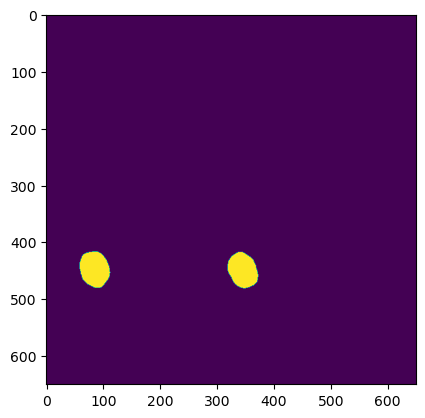

68 397
96 594
161 207
203 327
206 599
245 490
448 85
450 345
472 197
520 568
561 67
577 281
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [9]:
img = test_image[20,:,:,0]
img_bin = img > threshold
img_bin = img_bin.astype(int)
plt.imshow(img_bin)
plt.show()

result = []
for c in centers:
    x, y = c
    print(x, y)
    if img_bin[x, y] == 1:
        result.append(1)
    else:
         result.append(0)
print(result)

#co do k.!@#a

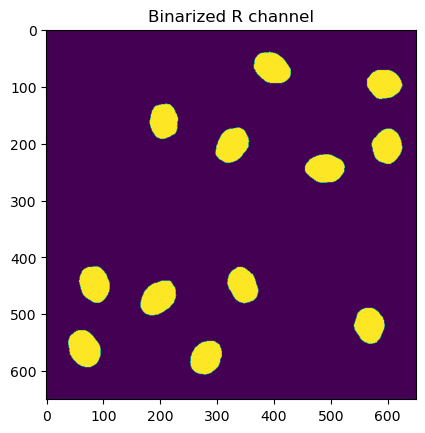

Number of cells:  12


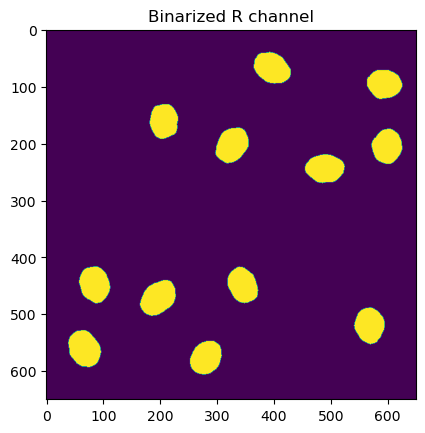

Number of cells:  12


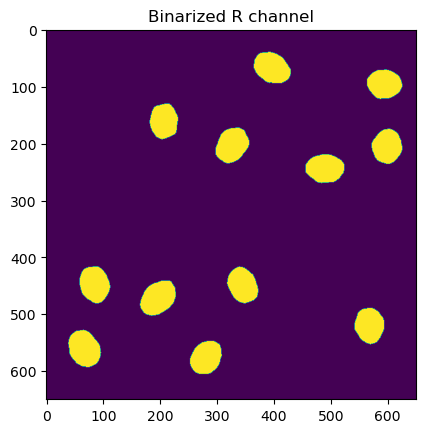

Number of cells:  12


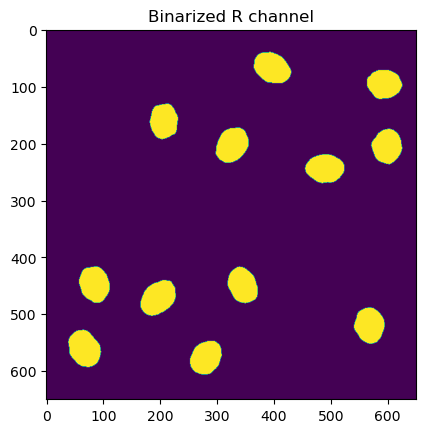

Number of cells:  12


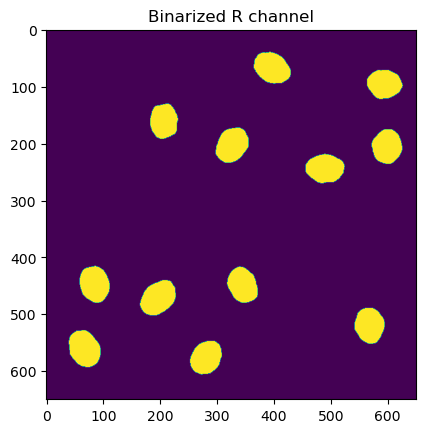

Number of cells:  12


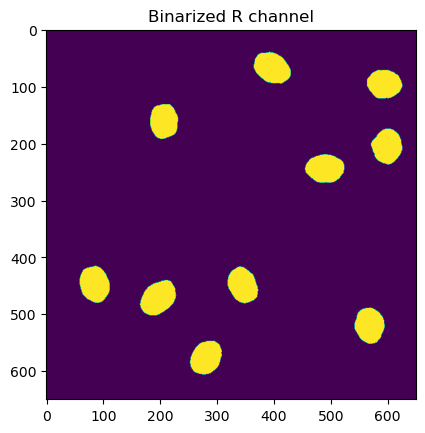

Number of cells:  10


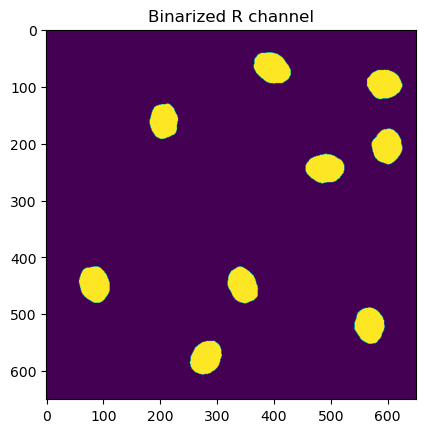

Number of cells:  9


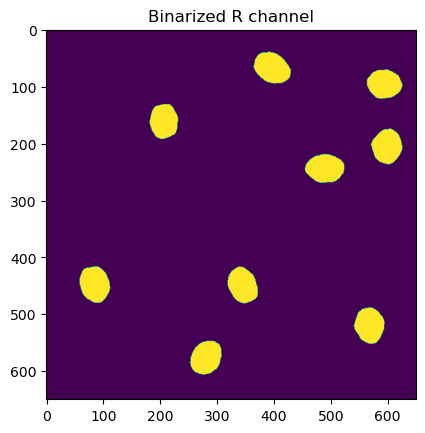

Number of cells:  9


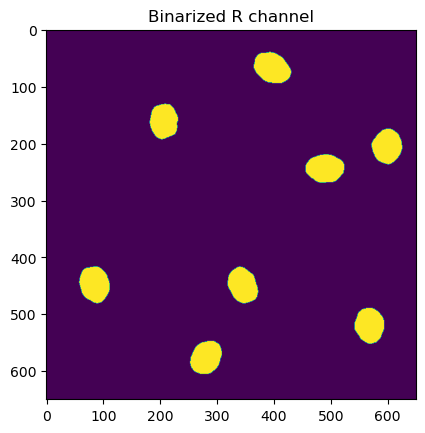

Number of cells:  8


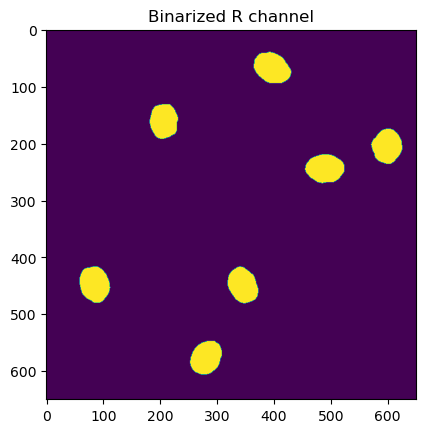

Number of cells:  7


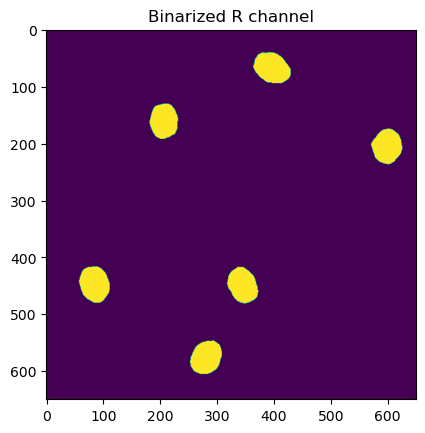

Number of cells:  6


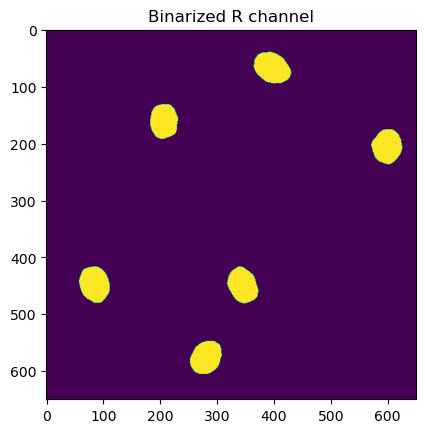

Number of cells:  6


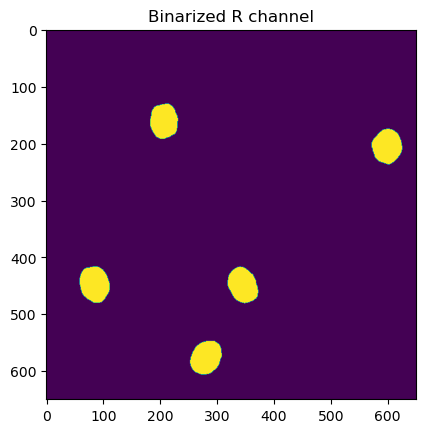

Number of cells:  5


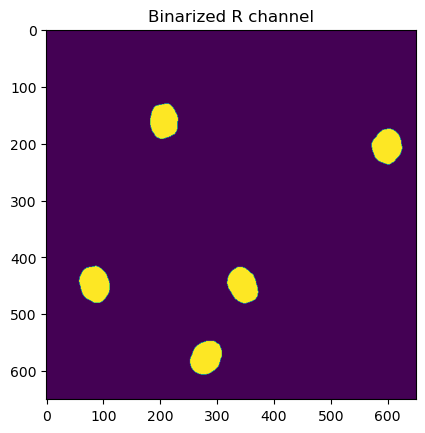

Number of cells:  5


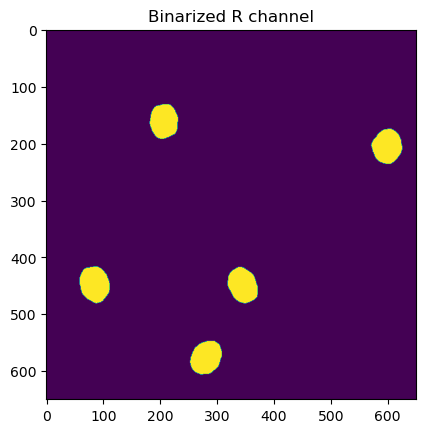

Number of cells:  5


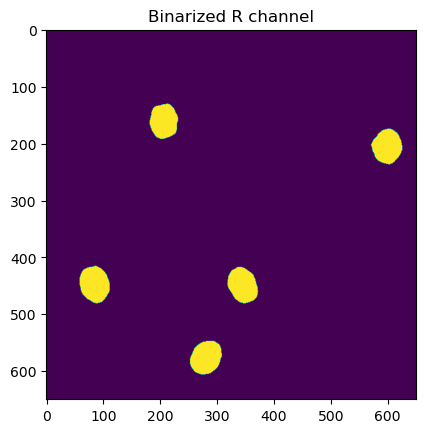

Number of cells:  5


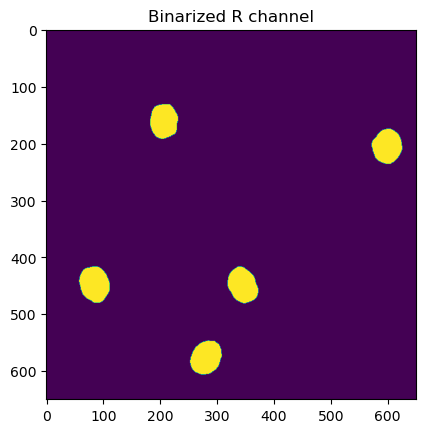

Number of cells:  5


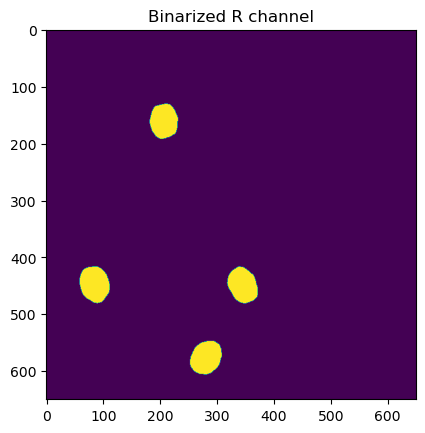

Number of cells:  4


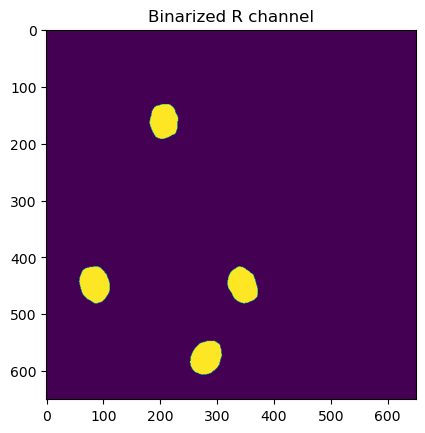

Number of cells:  4


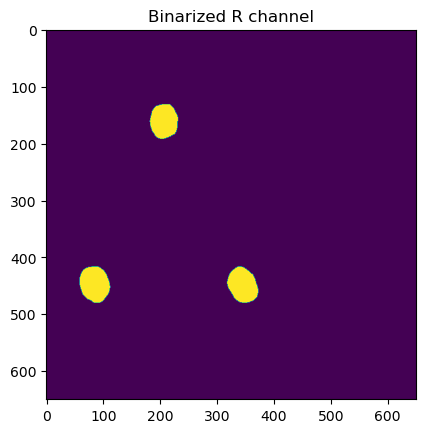

Number of cells:  3


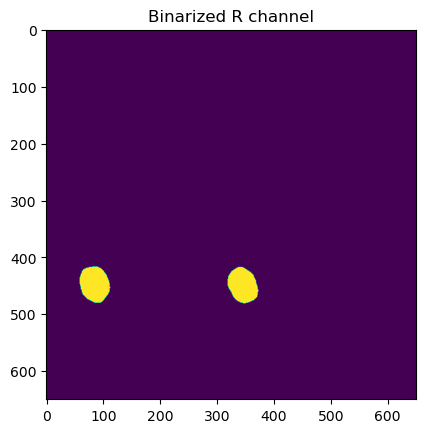

Number of cells:  2
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 4
15 4
16 4
17 4
18 4
19 4
20 4
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
11 5
12 5
13 5
14 5
15 5
16 5
17 5
18 5
19 5
20 5
0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
11 6
12 6
13 6
14 6
15 6
16 6
17 6
18 6
19 6
20 6
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
11 7
12 7
13 7
14 7
15 7
16 7
17 7
18 7
19 7
20 7
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
11 8
12 8
13 8
14 8
15 8
16 8
17 8
18 8
19 8
20 8
0 9
1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
9 9
10 9
11 9
12 9
13 9
14 9
15 9
16 9
17 9
18 9
19 9
20 9
0 10
1 10
2 10
3 10
4 10
5 10


In [10]:
result_all = []
cell_areas_all = []
for i in range(T):

    img = test_image[i,:,:,0]  
    img_bin = img > threshold
    img_bin = img_bin.astype(int)

    #plot binarized image
    plt.imshow(img_bin)
    plt.title('Binarized R channel')
    plt.show()

    #check if centers we already have are still 0 in the binarized image
    # Check the centers
    result = check_centers(img_bin, centers)
    result_all.append(result)
#print(result_all)          
    #result all is a list of lists, where each column is data for 1 cell in time
    #change each column of result_all to a vector and append it to metadata['Alive']
    #change result_all to an array

    img_R_label = measure.label(img_bin)

    #counting the number of cells
    num_cells = img_R_label.max()
    print('Number of cells: ', num_cells)

    #print location of the cells
    #finding the center of the cells
    props = measure.regionprops(img_R_label)
    # Zbieranie obszarów komórek
    cell_areas = [region.area for region in props]



    #mistake!!!!!!!!!!!!!!!!!
    
    new_vector = np.zeros(len(centers))
    for t in range(sum(np.array(result)==1)):
        new_vector[np.where(np.array(result)==1)[0][t]] = cell_areas[t]

    cell_areas_all.append(new_vector)

result_all = np.array(result_all)
cell_areas_all = np.array(cell_areas_all)


for d in range(len(result)):
    for z in range(T):
        metadata['Alive'].append(result_all[z,d])
        metadata['nuclei_size'].append(cell_areas_all[z,d])
        print(z,d)





In [11]:
print(len(metadata['time']))
print(len(metadata['cell_number']))
print(len(metadata['x']))
print(len(metadata['y']))
print(len(metadata['Alive']))
print(len(metadata['nuclei_size']))
#change metadata to dataframe
metadata = pd.DataFrame(metadata)
print(metadata)

252
252
252
252
252
252
     time  cell_number    x    y  Alive  nuclei_size
0       0            1  397   68      1       2718.0
1       1            1  397   68      1       2711.0
2       2            1  397   68      1       2722.0
3       3            1  397   68      1       2731.0
4       4            1  397   68      1       2718.0
..    ...          ...  ...  ...    ...          ...
247    16           12  281  577      1       2561.0
248    17           12  281  577      1       2562.0
249    18           12  281  577      1       2555.0
250    19           12  281  577      0          0.0
251    20           12  281  577      0          0.0

[252 rows x 6 columns]
